# Import Libraries

In [1]:
import pickle
import umap
from tqdm import tqdm
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity
from skimage.registration import phase_cross_correlation

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
from IPython.display import Image

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore') 

/Users/liyuxiao/opt/anaconda3/envs/nii/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)


# Read Features

In [3]:
df = pd.read_json("/Users/liyuxiao/Downloads/nii_project/dataset/1.json")
df["char"] = df["data"].apply(lambda x: x["char"])
df["url"] = df["data"].apply(
    lambda x: "/Users/liyuxiao/Downloads/nii_project/" + x["url"][28:]
)

# single_char = [ele for ele in df_count.index if len(ele) == 1]
# df_single_char = df[df["char"].isin(single_char)]
df.loc[:, "image_file"] = df["url"].apply(lambda x: x[48:])

df_count = (
    df.groupby("char").count().sort_values(by=["data"], ascending=False)[["data"]]
)

with open(
    "/Users/liyuxiao/Downloads/nii_project/dataset/feature_data_3.pkl", "rb"
) as handle:
    data = pickle.load(handle)

# get a list of just the features
feat = np.array(list(data.values()))
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)

features = pd.DataFrame(data.items(), columns=["image_file", "features"])
features.features = features.features.apply(lambda x: x[0])

df = pd.merge(df, features, on="image_file")
df["index"] = df.index
df

data char  \
0      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   その   
1      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    子   
2      {'char': 'むまこ', 'url': 'http://codh.rois.ac.jp...  むまこ   
3      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  まては   
4      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  はふれ   
...                                                  ...  ...   
36875  {'char': '国の', 'url': 'http://codh.rois.ac.jp/...   国の   
36876  {'char': '愽', 'url': 'http://codh.rois.ac.jp/s...    愽   
36877  {'char': '士', 'url': 'http://codh.rois.ac.jp/s...    士   
36878  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    共   
36879  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    の   

                                                     url         image_file  \
0      /Users/liyuxiao/Downloads/nii_project/dataset/...      0_001_0_1.jpg   
1      /Users/liyuxiao/Downloads/nii_project/dataset/...      1_001_0_1.jpg   
2      /Users/liyuxiao/Downloads/nii_project/dataset/...      2_001_0_1.jpg   
3      /Users/liyuxiao/Downloads/nii_project/dataset/...      3_001_0_1.jpg   
4      /Users/liyuxiao/Downloads/nii_project/dataset/...      4_001_0_1.jpg   
...                                                  ...                ...   
36875  /Users/liyuxiao/Downloads/nii_project/dataset/...  36875_001_9_1.jpg   
36876  /Users/liyuxiao/Downloads/nii_project/dataset/...  36876_001_9_1.jpg   
36877  /Users/liyuxiao/Downloads/nii_project/dataset/...  36877_001_9_1.jpg   
36878  /Users/liyuxiao/Downloads/nii_project/dataset/...  36878_001_9_1.jpg   
36879  /Users/liyuxiao/Downloads/nii_project/dataset/...  36879_001_9_1.jpg   

                                                features  index  
0      [0.0, 0.17923433, 0.6853925, 0.0, 0.64076066, ...      0  
1      [0.0, 0.0649108, 0.7553543, 0.0, 1.88011, 0.0,...      1  
2      [0.0, 0.0, 1.0507239, 0.0, 0.0, 0.0, 0.9604052...      2  
3      [0.0, 0.0, 1.3613073, 0.0, 0.0, 0.0, 1.392827,...      3  
4      [1.0408874, 0.22247407, 0.0, 0.0, 0.0, 0.0, 0....      4  
...                                                  ...    ...  
36875  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3766487, 0.0,...  36875  
36876  [0.5601951, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5675526...  36876  
36877  [2.2734528, 0.0, 2.9041257, 0.0, 0.0, 1.136053...  36877  
36878  [0.50921106, 0.630736, 0.06636846, 0.0, 0.0, 0...  36878  
36879  [2.41373, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8572688, ...  36879  

[36880 rows x 6 columns]

In [4]:
char_list = df.char.unique()
char_list


array(['その', '子', 'むまこ', ..., 'もいにし', '篇', '愽'], dtype=object)

# Dimensionality Reduction

## TSNE + Kmeans

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
for char in tqdm(char_list):
    if len(df[df["char"] == char]) > 1:
        tsne_results = tsne.fit_transform(list(df[df["char"] == char].features))
        clustering = DBSCAN(eps=1, min_samples=2).fit(tsne_results)
        df.loc[df["char"] == char, "label"] = np.array(clustering.labels_, dtype=str)
        df.loc[df["char"] == char, "label"] = df.loc[
            df["char"] == char, "char"
        ].str.cat(df.loc[df["char"] == char, "label"], sep="_")
        df.loc[df["char"] == char, "x"] = tsne_results[:, 0]
        df.loc[df["char"] == char, "y"] = tsne_results[:, 1]
    else:
        df.loc[df["char"] == char, "label"] = df.loc[df["char"] == char, "char"]

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(list(df[df["char"] == "に"].features))


In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(tsne_results)


In [ ]:
plt.figure(figsize=(20, 12))
plt.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    s=10,
    c=clustering.labels_,
    cmap="rainbow",
)


In [ ]:
for url in df[df["char"] == "に"][clustering.labels_ == 8].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))


## UMAP+DBSCAN

In [5]:
for char in tqdm(char_list):
    if len(df[df["char"] == char]) > 10:
        standard_embedding = umap.UMAP(
            n_neighbors=5, min_dist=0.0, n_components=2, random_state=42
        ).fit_transform(list(df[df["char"] == char].features))

        clustering = DBSCAN(eps=2, min_samples=5).fit(standard_embedding)
        df.loc[df["char"] == char, "label"] = np.array(clustering.labels_, dtype=str)
        df.loc[df["char"] == char, "label"] = df.loc[
            df["char"] == char, "char"
        ].str.cat(df.loc[df["char"] == char, "label"], sep="_")
        df.loc[df["char"] == char, "x"] = standard_embedding[:, 0]
        df.loc[df["char"] == char, "y"] = standard_embedding[:, 1]
    else:
        df.loc[df["char"] == char, "label"] = df.loc[df["char"] == char, "char"]
        df.loc[df["char"] == char, "x"] = np.random.rand(len(df[df["char"] == char]), 1)
        df.loc[df["char"] == char, "y"] = np.random.rand(len(df[df["char"] == char]), 1)
# print(np.unique(clustering.labels_))

# plt.figure(figsize=(20, 12))
# plt.scatter(
#     standard_embedding[:, 0],
#     standard_embedding[:, 1],
#     s=1,
#     c=clustering.labels_,
#     cmap="Spectral",
# )

100%|██████████| 3913/3913 [05:41<00:00, 11.47it/s]


In [6]:
df_count.head(5)

data
char      
に     1375
の     1368
を     1044
て      976
は      970

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


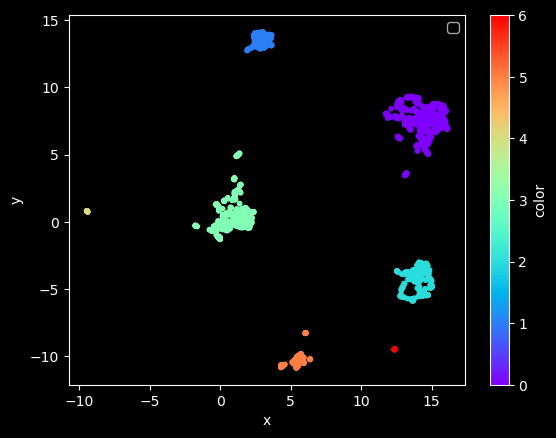

In [8]:
char = "の"
color_dict = {}
for idx, element in enumerate(np.unique(df.loc[df["char"] == char].label)):
    color_dict[element] = idx
df["color"] = df.loc[df["char"] == char, "label"].map(color_dict)

ax = df.plot.scatter(x="x", y="y", s=10, c="color", cmap="rainbow")
ax.legend()


In [140]:
df.to_csv("feature_data_3.csv", index=False)

### NN Search

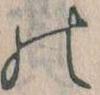

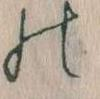

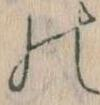

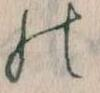

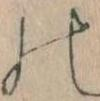

-----


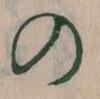

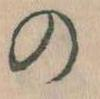

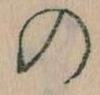

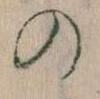

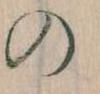

-----


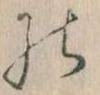

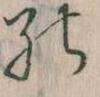

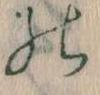

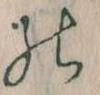

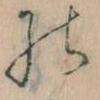

-----


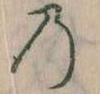

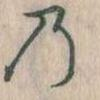

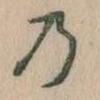

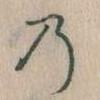

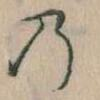

-----


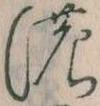

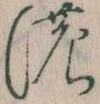

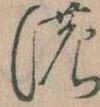

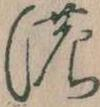

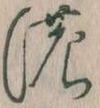

-----


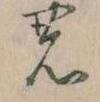

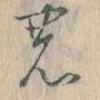

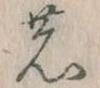

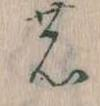

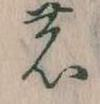

-----


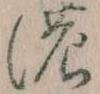

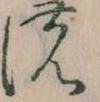

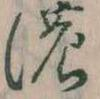

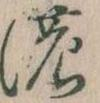

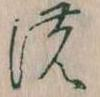

-----


In [158]:
for element in np.unique(df.loc[df["char"] == char].label):
    for url in df.loc[df["label"] == element].sample(5).url.values:
        display(Image(filename=url))
    print("-----")


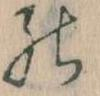

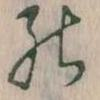

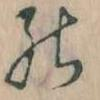

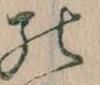

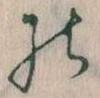

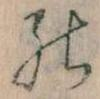

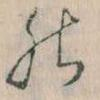

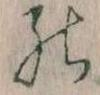

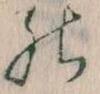

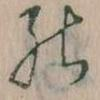

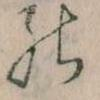

In [149]:
knn = NearestNeighbors(n_neighbors=11)
knn.fit(df.loc[df["char"] == char][["x", "y"]].values)

nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[467][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for url in df.loc[df["char"] == char].iloc[nei[0]].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))


### SIFT

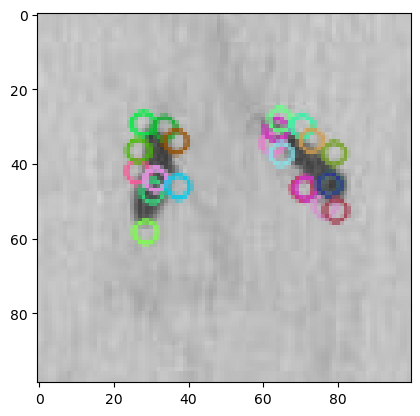

In [885]:
# reading image
img1 = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
    + df.loc[df["char"] == char].iloc[467].image_file
)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)

img_1 = cv2.drawKeypoints(gray1, keypoints_1, img1)
plt.imshow(img_1)
nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[467][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][3:]:
    # Load images
    img_2 = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )
    gray2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    # keypoints
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_2, descriptors_2 = sift.detectAndCompute(img_2, None)

    img_2 = cv2.drawKeypoints(gray2, keypoints_2, img_2)
    plt.imshow(img_2)

In [648]:
def get_similarity_from_desc(approach, search_desc, idx_desc):
    if approach == "sift" or approach == "orb_sift":
        # BFMatcher with euclidean distance
        bf = cv2.BFMatcher()
    else:
        # BFMatcher with hamming distance
        bf = cv2.BFMatcher(cv.NORM_HAMMING)
    matches = bf.match(search_desc, idx_desc)
    # Distances between search and index features that match
    distances = [m.distance for m in matches]
    # Distance between search and index images
    distance = sum(distances) / len(distances)
    # If distance == 0 -> similarity = 1
    similarity = 1 / (1 + distance)
    return similarity


### phase_cross_correlation 

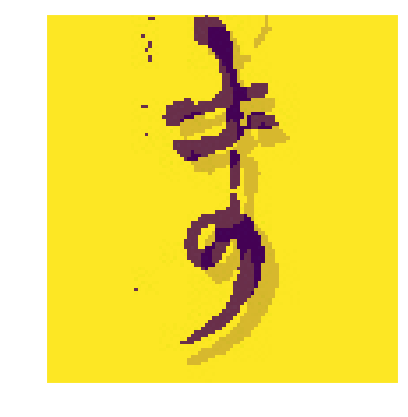

Detected subpixel offset (y, x): [4. 4.]


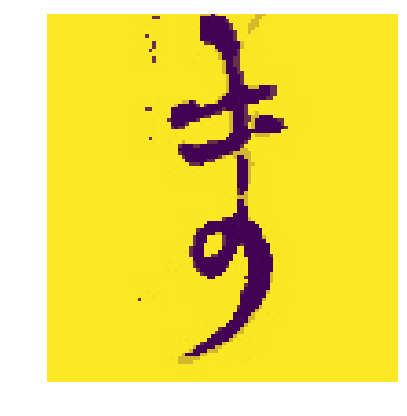

Image Structure Similarity: 87.9459%
---------


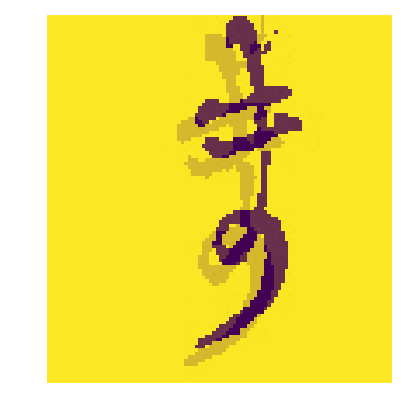

Detected subpixel offset (y, x): [ 5. -4.]


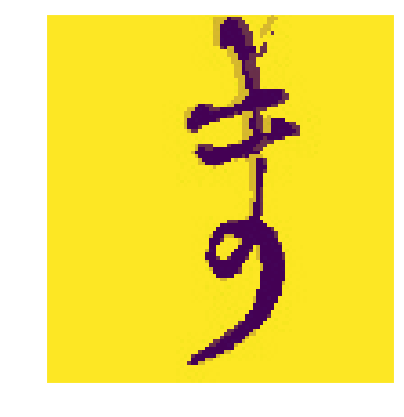

Image Structure Similarity: 87.8873%
---------


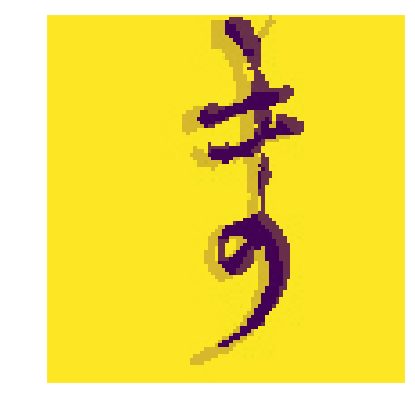

Detected subpixel offset (y, x): [ 1. -4.]


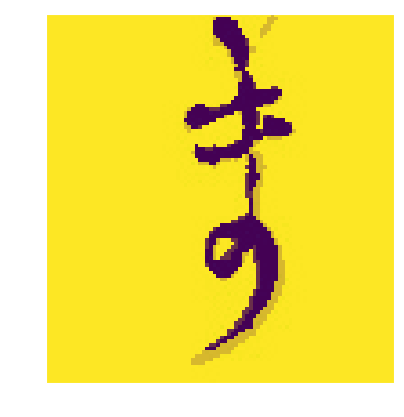

Image Structure Similarity: 87.1889%
---------


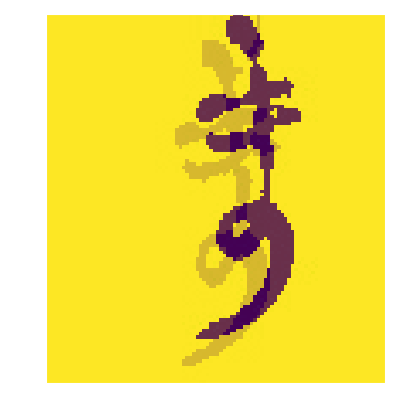

Detected subpixel offset (y, x): [ 8. -7.]


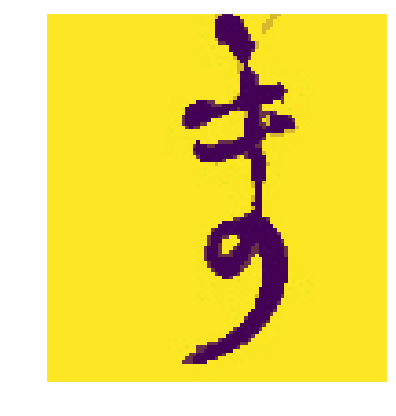

Image Structure Similarity: 91.1277%
---------


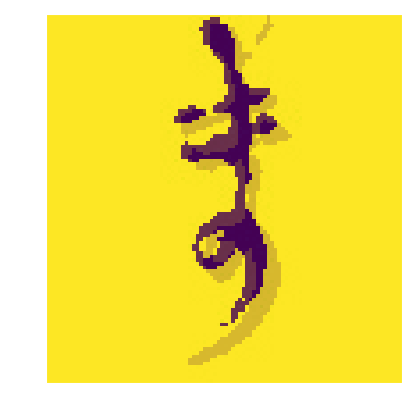

Detected subpixel offset (y, x): [2. 3.]


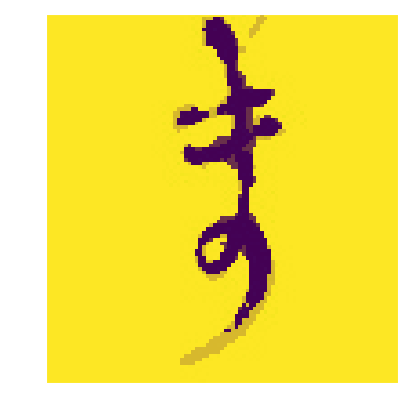

Image Structure Similarity: 87.1665%
---------


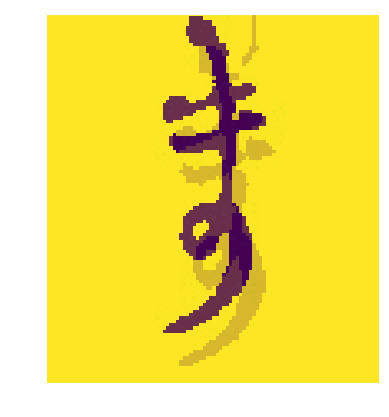

Detected subpixel offset (y, x): [9. 3.]


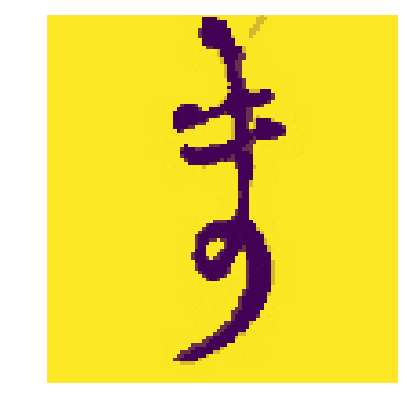

Image Structure Similarity: 90.1448%
---------


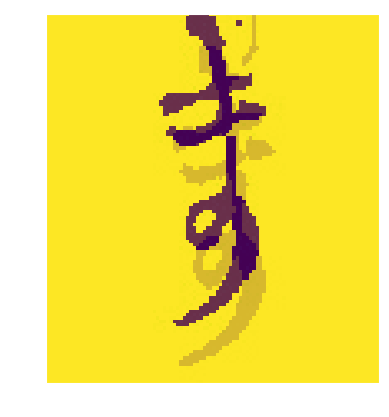

Detected subpixel offset (y, x): [11.  2.]


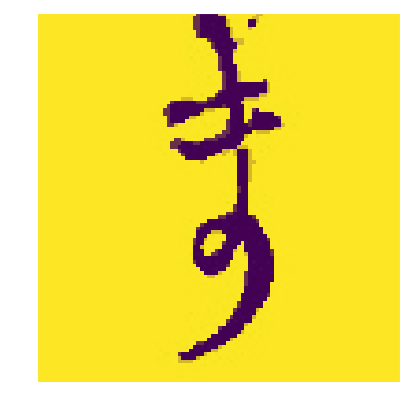

Image Structure Similarity: 91.6865%
---------


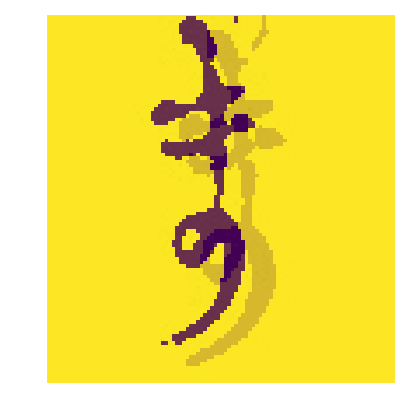

Detected subpixel offset (y, x): [4. 8.]


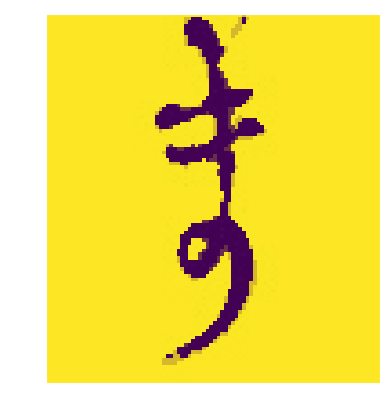

Image Structure Similarity: 91.5645%
---------


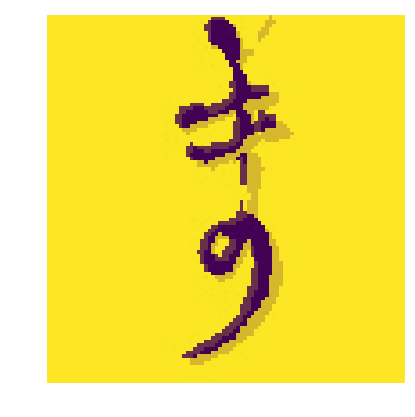

Detected subpixel offset (y, x): [2. 1.]


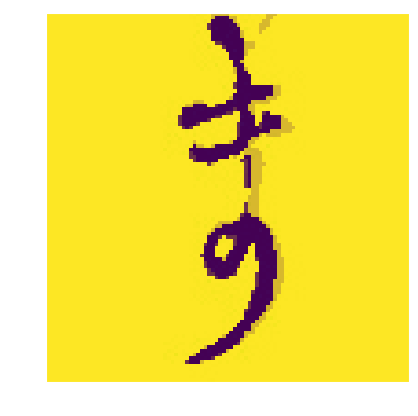

Image Structure Similarity: 88.8679%
---------


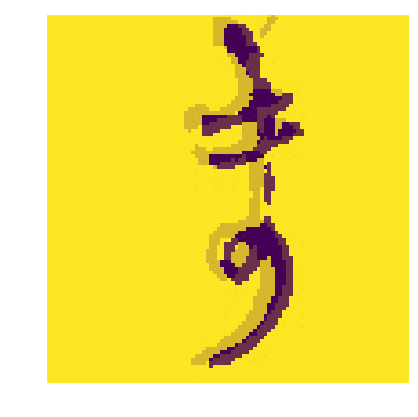

Detected subpixel offset (y, x): [-1. -4.]


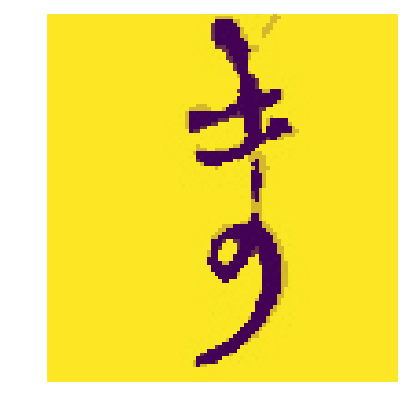

Image Structure Similarity: 89.2492%
---------


In [66]:
char = "ま"
# Load images
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + df.loc[df["char"] == char].iloc[176].image_file
)

knn = NearestNeighbors(n_neighbors=11)
knn.fit(df.loc[df["char"] == char][["x", "y"]].values)

nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[176][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][1:]:
    # Load images
    imgTest = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )

    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    fig = plt.figure(frameon=False)
    cv2_imshow(imgRef_grey)
    cv2_imshow(imgTest_grey, alpha=0.8)
    plt.show()

    # pixel precision first
    shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
    print(f"Detected subpixel offset (y, x): {shift}")

    height_offset, weith_offset = int(shift[0]), int(shift[1])

    if height_offset > 0 and weith_offset > 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[height_offset:, weith_offset:])
        cv2_imshow(imgTest_grey[:-height_offset, :-weith_offset], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[height_offset:, weith_offset:],
            imgTest_grey[:-height_offset, :-weith_offset],
            full=True,
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset > 0 and weith_offset < 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[height_offset:, :weith_offset])
        cv2_imshow(imgTest_grey[:-height_offset, -weith_offset:], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[height_offset:, :weith_offset],
            imgTest_grey[:-height_offset, -weith_offset:],
            full=True,
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset < 0 and weith_offset > 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[:height_offset, weith_offset:])
        cv2_imshow(imgTest_grey[-height_offset:, :-weith_offset], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[:height_offset, weith_offset:],
            imgTest_grey[-height_offset:, :-weith_offset],
            full=True,
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset < 0 and weith_offset < 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[:height_offset, :weith_offset])
        cv2_imshow(imgTest_grey[-height_offset:, -weith_offset:], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[:height_offset, :weith_offset],
            imgTest_grey[-height_offset:, -weith_offset:],
            full=True,
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset == 0 and weith_offset > 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[:, weith_offset:])
        cv2_imshow(imgTest_grey[:, :-weith_offset], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[:, weith_offset:], imgTest_grey[:, :-weith_offset], full=True
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset == 0 and weith_offset < 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[:, :weith_offset])
        cv2_imshow(imgTest_grey[:, -weith_offset:], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[:, :weith_offset], imgTest_grey[:, -weith_offset:], full=True
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset > 0 and weith_offset == 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[height_offset:, :])
        cv2_imshow(imgTest_grey[:-height_offset, :], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[height_offset:, :], imgTest_grey[:-height_offset, :], full=True
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    elif height_offset < 0 and weith_offset == 0:
        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey[:height_offset, :])
        cv2_imshow(imgTest_grey[-height_offset:, :], alpha=0.8)
        plt.show()
        (score, diff) = structural_similarity(
            imgRef_grey[:height_offset, :], imgTest_grey[-height_offset:, :], full=True
        )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
    print("---------")


In [ ]:
for char in tqdm(np.unique(df.char)):
    for idx, row in df.loc[df["char"] == char].iterrows():
        # Load Ref images
        imgRef = cv2.imread(
            "/Users/liyuxiao/Downloads/nii_project/dataset/2/" + row["image_file"]
        )
        # Find nearest neighbors
        knn = NearestNeighbors(n_neighbors=6)
        knn.fit(df.loc[df["char"] == char][["x", "y"]].values)

        nei = knn.kneighbors(
            row[["x", "y"]].values.reshape(1, -1),
            return_distance=False,
        )
        for i in nei[0][1:]:
            # Load Neighbor images
            imgTest = cv2.imread(
                "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
                + df.loc[df["char"] == char].iloc[i].image_file
            )

            # Convert to grayscale.
            imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
            imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

            height1, width1 = imgRef_grey.shape
            height2, width2 = imgTest_grey.shape

            height_max = max(height1, height2)
            width_max = max(width1, width2)

            # Pad the images to same size
            imgRef_grey = cv2.copyMakeBorder(
                imgRef_grey,
                height_max - height1,
                0,
                width_max - width1,
                0,
                cv2.BORDER_REPLICATE,
            )
            imgTest_grey = cv2.copyMakeBorder(
                imgTest_grey,
                height_max - height2,
                0,
                width_max - width2,
                0,
                cv2.BORDER_REPLICATE,
            )

            # pixel precision first
            shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
            print(f"Detected subpixel offset (y, x): {shift}")

            height_offset, weith_offset = int(shift[0]), int(shift[1])

            # Compute Similarity
            if height_offset > 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, weith_offset:],
                    imgTest_grey[:-height_offset, :-weith_offset],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :weith_offset],
                    imgTest_grey[:-height_offset, -weith_offset:],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, weith_offset:],
                    imgTest_grey[-height_offset:, :-weith_offset],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :weith_offset],
                    imgTest_grey[-height_offset:, -weith_offset:],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, weith_offset:],
                    imgTest_grey[:, :-weith_offset],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, :weith_offset],
                    imgTest_grey[:, -weith_offset:],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :],
                    imgTest_grey[:-height_offset, :],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :],
                    imgTest_grey[-height_offset:, :],
                    full=True,
                )
                print("Image Structure Similarity: {:.4f}%".format(score * 100))
            print("---------")


In [9]:
df["score"] = 0


In [14]:
for char in tqdm(np.unique(df.char)):
    if len(df.loc[df["char"] == char]) >= 11:
        # Find nearest neighbors
        knn = NearestNeighbors(n_neighbors=11)
    else:
        knn = NearestNeighbors(n_neighbors=len(df.loc[df["char"] == char]))
    knn.fit(df.loc[df["char"] == char][["x", "y"]].values)
    for idx, row in df.loc[df["char"] == char].iterrows():
        # Load Ref images
        imgRef = cv2.imread(
            "/Users/liyuxiao/Downloads/nii_project/dataset/2/" + row["image_file"]
        )
        temp = 0
        nei = knn.kneighbors(
            row[["x", "y"]].values.reshape(1, -1),
            return_distance=False,
        )
        for i in nei[0][1:]:
            # Load Neighbor images
            imgTest = cv2.imread(
                "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
                + df.loc[df["char"] == char].iloc[i].image_file
            )

            # Convert to grayscale.
            imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
            imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

            height1, width1 = imgRef_grey.shape
            height2, width2 = imgTest_grey.shape

            height_max = max(height1, height2)
            width_max = max(width1, width2)

            # Pad the images to same size
            imgRef_grey = cv2.copyMakeBorder(
                imgRef_grey,
                height_max - height1,
                0,
                width_max - width1,
                0,
                cv2.BORDER_REPLICATE,
            )
            imgTest_grey = cv2.copyMakeBorder(
                imgTest_grey,
                height_max - height2,
                0,
                width_max - width2,
                0,
                cv2.BORDER_REPLICATE,
            )

            # pixel precision first
            shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
            # print(f"Detected subpixel offset (y, x): {shift}")

            height_offset, weith_offset = int(shift[0]), int(shift[1])

            # Compute Similarity
            if height_offset > 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, weith_offset:],
                    imgTest_grey[:-height_offset, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :weith_offset],
                    imgTest_grey[:-height_offset, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, weith_offset:],
                    imgTest_grey[-height_offset:, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :weith_offset],
                    imgTest_grey[-height_offset:, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, weith_offset:],
                    imgTest_grey[:, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, :weith_offset],
                    imgTest_grey[:, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :],
                    imgTest_grey[:-height_offset, :],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :],
                    imgTest_grey[-height_offset:, :],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            if score > temp:
                df.at[idx, "NN"] = int(df.loc[df["char"] == char].iloc[i]["index"])
                df.at[idx, "score"] = score
        # print("---------")

100%|██████████| 3913/3913 [41:26<00:00,  1.57it/s]  


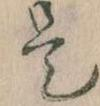

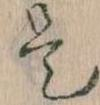

--------


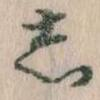

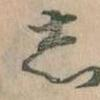

--------


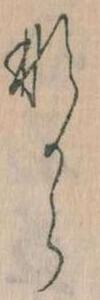

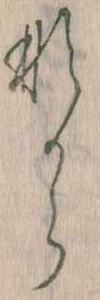

--------


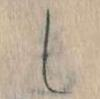

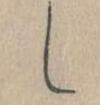

--------


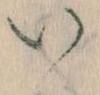

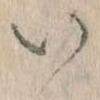

--------


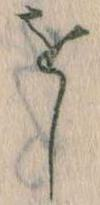

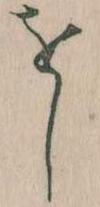

--------


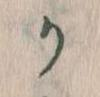

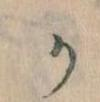

--------


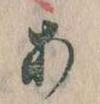

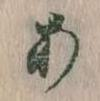

--------


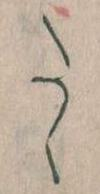

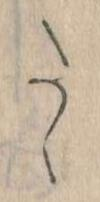

--------


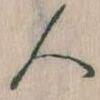

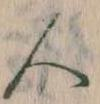

--------


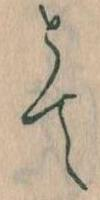

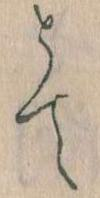

--------


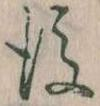

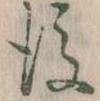

--------


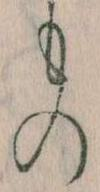

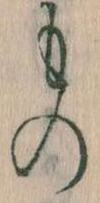

--------


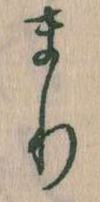

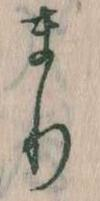

--------


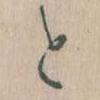

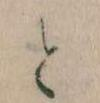

--------


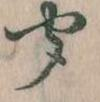

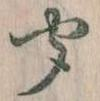

--------


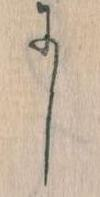

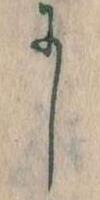

--------


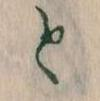

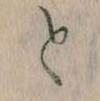

--------


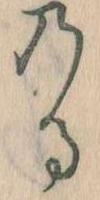

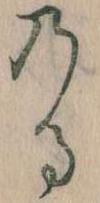

--------


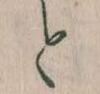

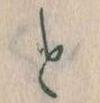

--------


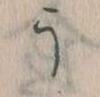

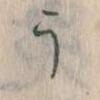

--------


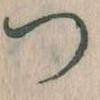

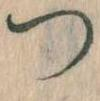

--------


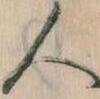

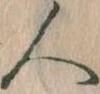

--------


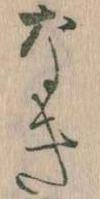

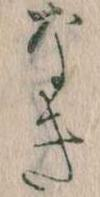

--------


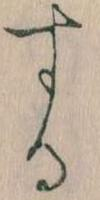

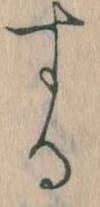

--------


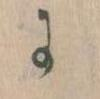

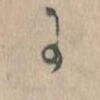

--------


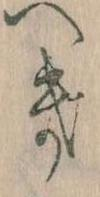

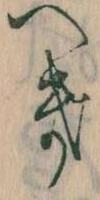

--------


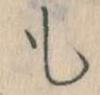

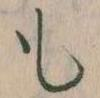

--------


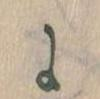

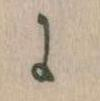

--------


In [120]:
for idx, row in df.sample(50).iterrows():
    if row["score"] > 0.8 and not np.isnan(row["NN"]):
        display(Image(filename=row.url))
        display(Image(filename=df.iloc[int(row["NN"])].url))

        print("--------")

In [121]:
df[df["score"] > 0.8]


data char  \
3      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  まては   
5      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    に   
7      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   なを   
10     {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   はる   
13     {'char': 'ゆゝ', 'url': 'http://codh.rois.ac.jp/...   ゆゝ   
...                                                  ...  ...   
36862  {'char': 'あ', 'url': 'http://codh.rois.ac.jp/s...    あ   
36863  {'char': 'はれ', 'url': 'http://codh.rois.ac.jp/...   はれ   
36868  {'char': 'こと', 'url': 'http://codh.rois.ac.jp/...   こと   
36871  {'char': '華', 'url': 'http://codh.rois.ac.jp/s...    華   
36872  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    の   

                                                     url         image_file  \
3      /Users/liyuxiao/Downloads/nii_project/dataset/...      3_001_0_1.jpg   
5      /Users/liyuxiao/Downloads/nii_project/dataset/...      5_001_0_1.jpg   
7      /Users/liyuxiao/Downloads/nii_project/dataset/...      7_001_0_1.jpg   
10     /Users/liyuxiao/Downloads/nii_project/dataset/...     10_001_0_1.jpg   
13     /Users/liyuxiao/Downloads/nii_project/dataset/...     13_001_0_1.jpg   
...                                                  ...                ...   
36862  /Users/liyuxiao/Downloads/nii_project/dataset/...  36862_001_9_1.jpg   
36863  /Users/liyuxiao/Downloads/nii_project/dataset/...  36863_001_9_1.jpg   
36868  /Users/liyuxiao/Downloads/nii_project/dataset/...  36868_001_9_1.jpg   
36871  /Users/liyuxiao/Downloads/nii_project/dataset/...  36871_001_9_1.jpg   
36872  /Users/liyuxiao/Downloads/nii_project/dataset/...  36872_001_9_1.jpg   

                                                features  index label  \
3      [0.0, 0.0, 1.3613073, 0.0, 0.0, 0.0, 1.392827,...      3   まては   
5      [0.27544352, 0.0, 0.0, 0.0, 0.0, 0.5119164, 2....      5   に_0   
7      [0.0, 0.43769503, 0.957344, 0.0, 0.0, 0.0, 0.8...      7  なを_0   
10     [0.0, 0.0, 0.0, 0.0, 1.9268657, 0.0, 1.9010222...     10  はる_0   
13     [0.0, 0.7759743, 0.7938897, 0.0, 0.0, 0.483807...     13    ゆゝ   
...                                                  ...    ...   ...   
36862  [0.82232714, 0.0, 1.7748972, 0.0, 0.45846862, ...  36862   あ_0   
36863  [2.3162785, 0.45709097, 0.96995145, 0.0, 0.117...  36863  はれ_1   
36868  [0.7730272, 0.344298, 0.119454384, 0.0, 0.0, 0...  36868  こと_1   
36871  [0.0, 0.0, 0.0, 0.0, 0.0, 0.89314127, 2.994887...  36871     華   
36872  [0.84106225, 0.0, 0.03921497, 0.0, 0.018304288...  36872   の_3   

              x          y  color     score       NN  
3      0.960637   0.010539    NaN  0.834046  21513.0  
5     -4.413189  -1.999055    NaN  0.898532  14489.0  
7      1.140340   2.799035    NaN  0.802901    371.0  
10     3.701196   0.878149    NaN  0.900849  30720.0  
13     0.133892   0.794210    NaN  0.858957  17741.0  
...         ...        ...    ...       ...      ...  
36862  8.495635  10.200994    NaN  0.841346  14942.0  
36863  0.581080  21.910263    NaN  0.866334   2362.0  
36868 -3.736027   6.050611    NaN  0.933193  14446.0  
36871  0.052339   0.145802    NaN  0.818318  24403.0  
36872  1.880177  -0.414288    3.0  0.891494  36522.0  

[17271 rows x 12 columns]

### Edge Detection

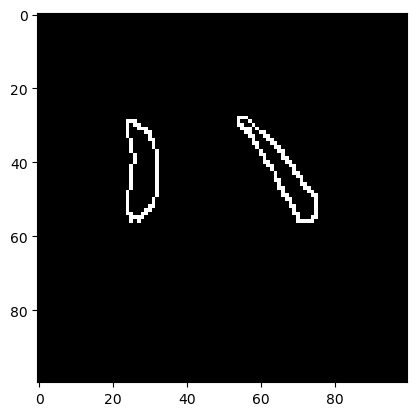

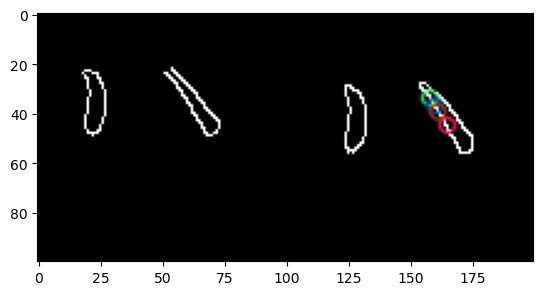

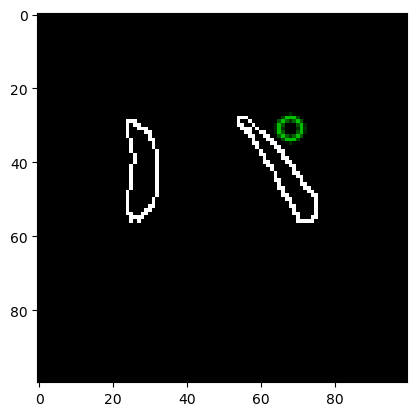

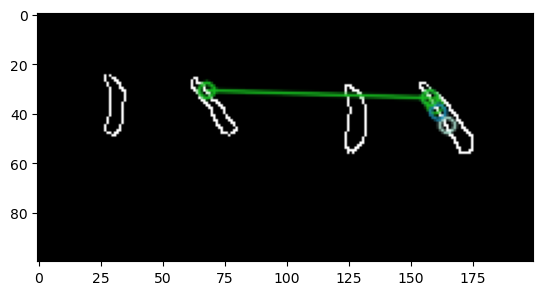

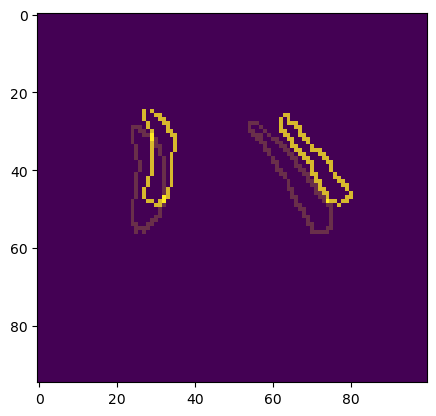

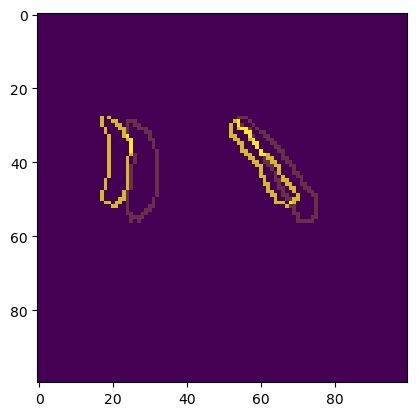

Image Structure Similarity: 80.0620%
Image self-defined Similarity: 0.2402%


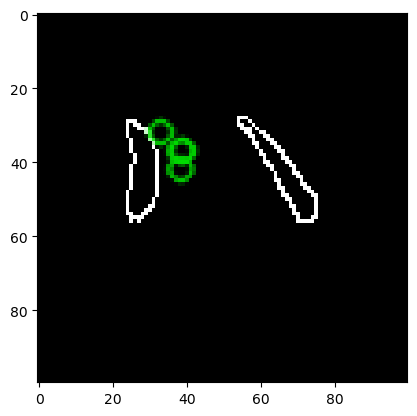

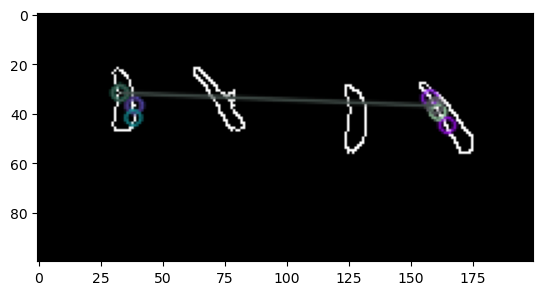

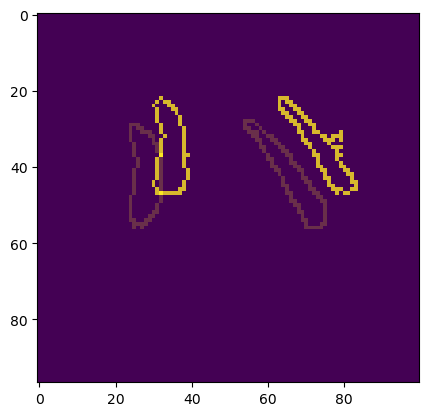

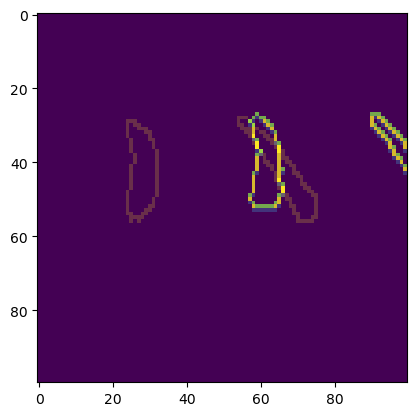

Image Structure Similarity: 80.3456%
Image self-defined Similarity: 0.2843%


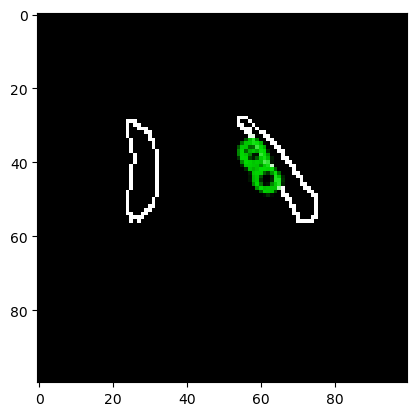

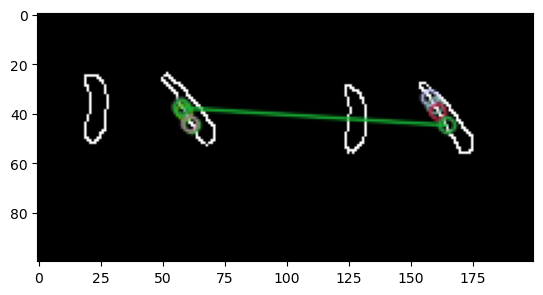

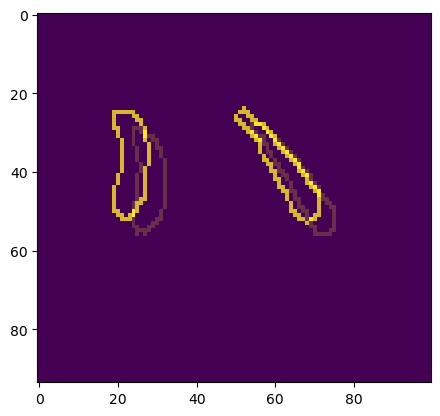

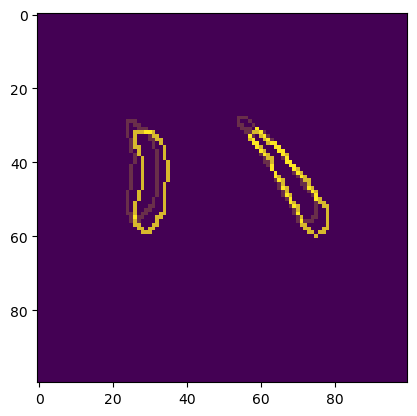

Image Structure Similarity: 82.9643%
Image self-defined Similarity: 0.2565%


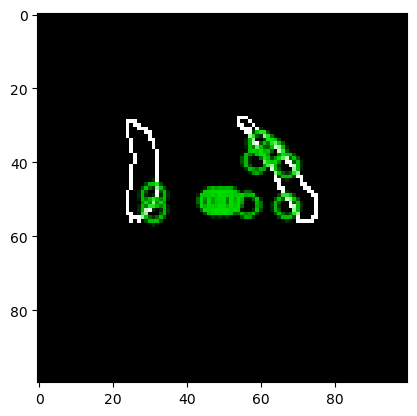

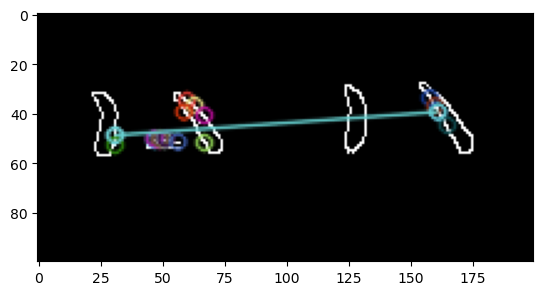

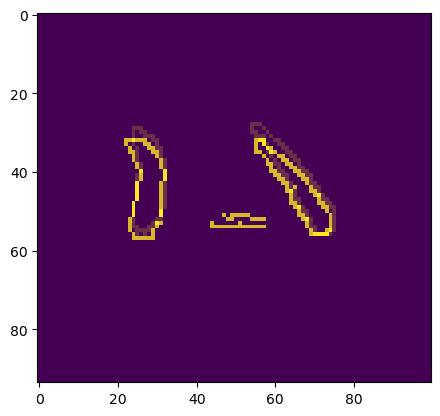

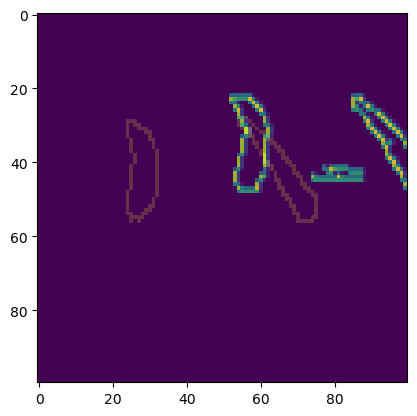

Image Structure Similarity: 77.5296%
Image self-defined Similarity: 0.2347%


In [916]:
# Load images
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
    + df.loc[df["char"] == char].iloc[22].image_file
)
imgRef = cv2.Canny(imgRef, 100, 200)

nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[22][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][1:]:
    # Load images
    imgTest = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )
    imgTest = cv2.Canny(imgTest, 100, 200)

    height, width = imgTest.shape

    # Configure ORB feature detector Algorithm with 1000 features.
    orb_detector = cv2.ORB_create(1000)

    # Extract key points and descriptors for both images
    (kpsA, descsA) = orb_detector.detectAndCompute(imgTest, None)
    (kpsB, descsB) = orb_detector.detectAndCompute(imgRef, None)

    # Display keypoints for reference image in green color
    imgKp_Ref = cv2.drawKeypoints(imgRef, kpsA, 0, (0, 222, 0), None)

    cv2_imshow(imgKp_Ref)
    plt.show()

    # Match features between two images using Brute Force matcher with Hamming distance
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)

    # Match the two sets of descriptors.
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x: x.distance)
    # keep only the top matches
    keep = 1
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints

    matchedVis = cv2.drawMatches(imgTest, kpsA, imgRef, kpsB, matches, None)
    cv2_imshow(matchedVis)
    plt.show()

    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for i, m in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
    # points
    # (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    H = np.float32(
        [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
    )
    if not np.isnan(H[0, 2]) and not np.isnan(H[1, 2]):
        (h, w) = imgRef.shape[:2]
        aligned = cv2.warpAffine(imgTest, H, (w, h))
        h_t = abs(math.ceil(H[0, 2]))
        w_t = abs(math.ceil(H[1, 2]))

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef)
        cv2_imshow(imgTest, alpha=0.8)
        plt.show()

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef)
        cv2_imshow(aligned, alpha=0.8)
        plt.show()

        # Compute SSIM between the two images
        if w_t != 0 and h_t != 0:
            (score, diff) = structural_similarity(
                imgRef[w_t:-w_t, h_t:-h_t], aligned[w_t:-w_t, h_t:-h_t], full=True
            )
        elif w_t == 0:
            (score, diff) = structural_similarity(
                imgRef[:, h_t:-h_t], aligned[:, h_t:-h_t], full=True
            )
        else:
            (score, diff) = structural_similarity(
                imgRef[w_t:-w_t:, :], aligned[w_t:-w_t:, :], full=True
            )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
        print(
            "Image self-defined Similarity: {:.4f}%".format(
                get_similarity_from_desc("sift", descsA, descsB) * 100
            )
        )


### SIFT features match

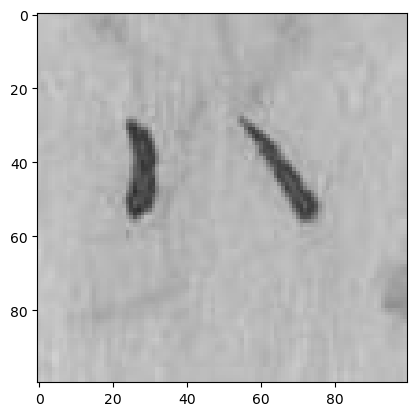

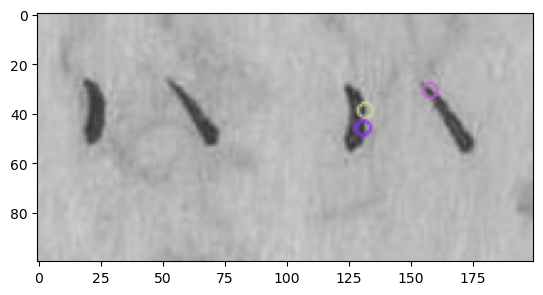

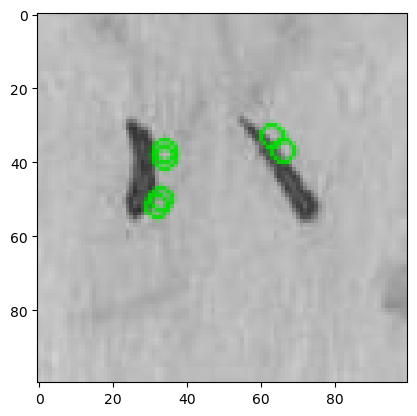

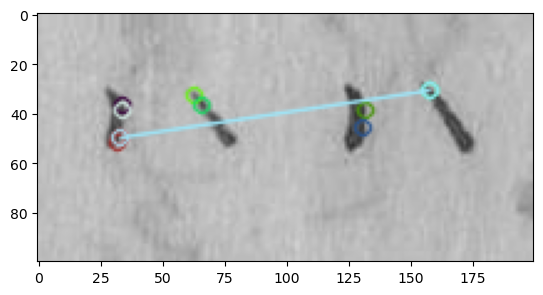

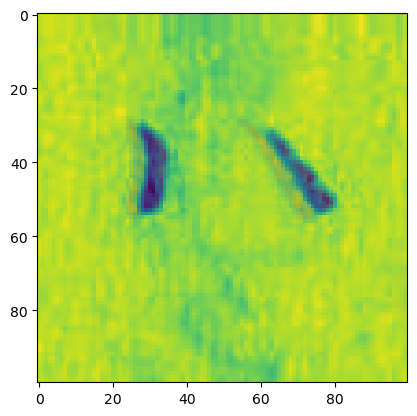

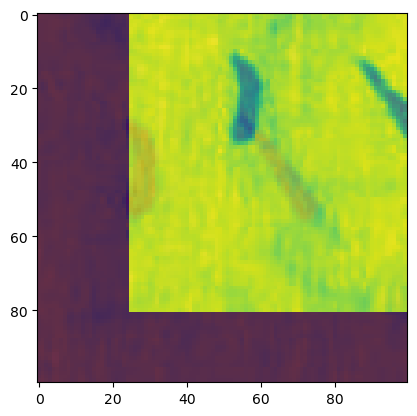

Image Structure Similarity: 45.6296%
Image self-defined Similarity: 0.2632%


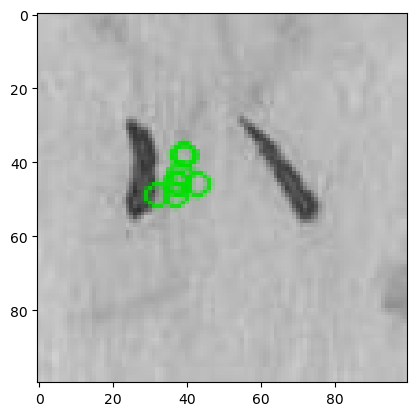

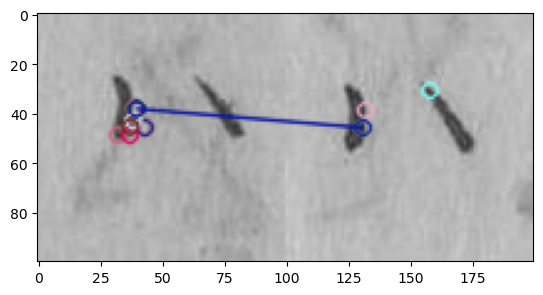

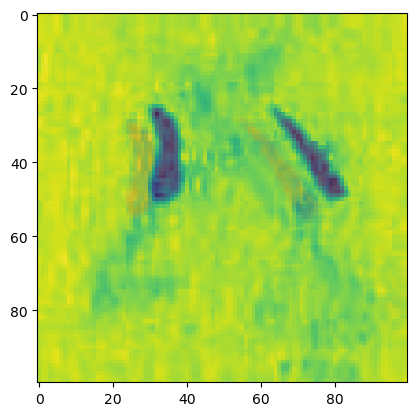

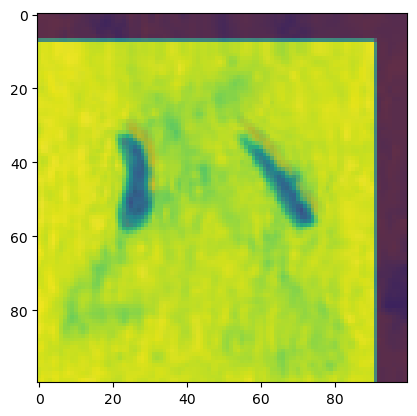

Image Structure Similarity: 56.0721%
Image self-defined Similarity: 0.2487%


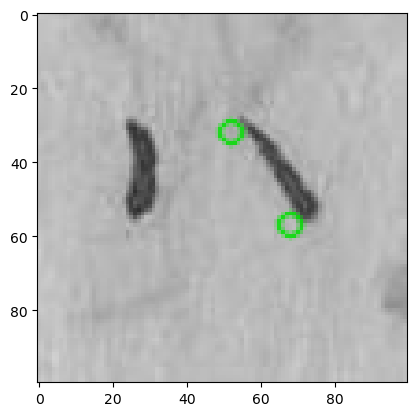

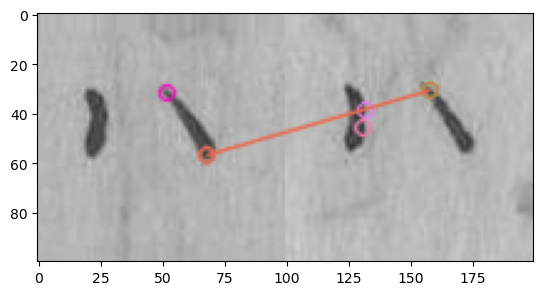

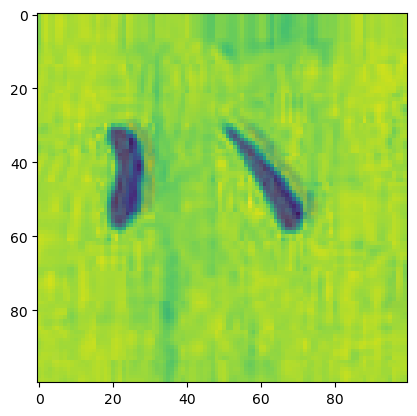

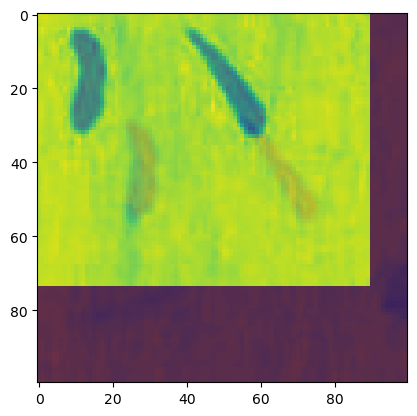

Image Structure Similarity: 50.3529%
Image self-defined Similarity: 0.2571%


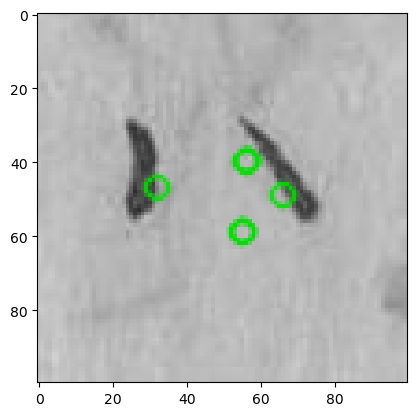

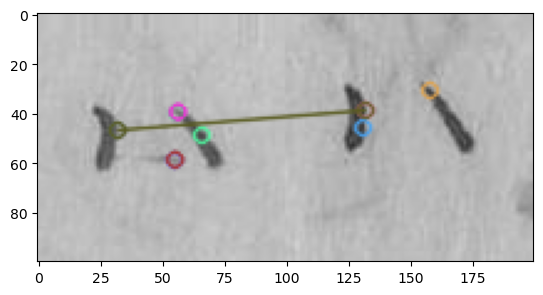

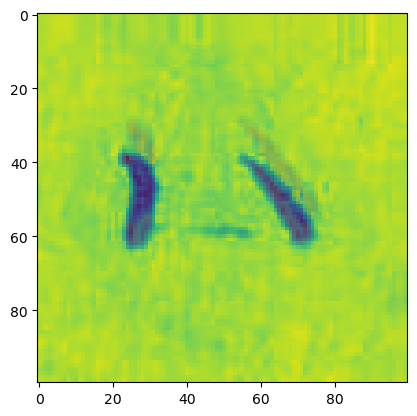

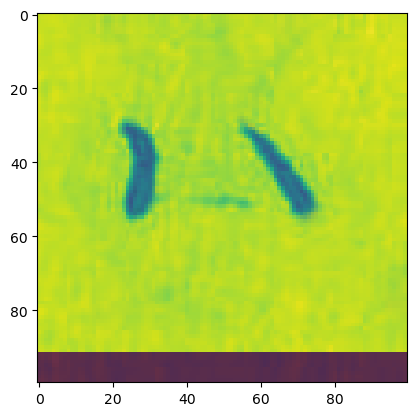

Image Structure Similarity: 68.4433%
Image self-defined Similarity: 0.2284%


In [968]:
# Load images
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
    + df.loc[df["char"] == char].iloc[22].image_file
)
nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[22][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][1:]:
    # Load images
    imgTest = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )

    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    # Configure ORB feature detector Algorithm with 1000 features.
    orb_detector = cv2.ORB_create(1000)

    # Extract key points and descriptors for both images
    (kpsA, descsA) = orb_detector.detectAndCompute(imgTest_grey, None)
    (kpsB, descsB) = orb_detector.detectAndCompute(imgRef_grey, None)

    # Display keypoints for reference image in green color
    imgKp_Ref = cv2.drawKeypoints(imgRef_grey, kpsA, 0, (0, 222, 0), None)

    cv2_imshow(imgKp_Ref)
    plt.show()

    # Match features between two images using Brute Force matcher with Hamming distance
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)

    # Match the two sets of descriptors.
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x: x.distance)
    # keep only the top matches
    keep = 1
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints

    matchedVis = cv2.drawMatches(imgTest_grey, kpsA, imgRef_grey, kpsB, matches, None)
    cv2_imshow(matchedVis)
    plt.show()

    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for i, m in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
    # points
    # (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    H = np.float32(
        [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
    )
    if not np.isnan(H[0, 2]) and not np.isnan(H[1, 2]):
        (h, w) = imgRef_grey.shape[:2]
        aligned = cv2.warpAffine(imgTest_grey, H, (w, h))
        h_t = abs(math.ceil(H[0, 2]))
        w_t = abs(math.ceil(H[1, 2]))

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey)
        cv2_imshow(imgTest_grey, alpha=0.8)
        plt.show()

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey)
        cv2_imshow(aligned, alpha=0.8)
        plt.show()

        # Compute SSIM between the two images
        if w_t != 0 and h_t != 0:
            (score, diff) = structural_similarity(
                imgRef_grey[w_t:-w_t, h_t:-h_t], aligned[w_t:-w_t, h_t:-h_t], full=True
            )
        elif w_t == 0:
            (score, diff) = structural_similarity(
                imgRef_grey[:, h_t:-h_t], aligned[:, h_t:-h_t], full=True
            )
        else:
            (score, diff) = structural_similarity(
                imgRef_grey[w_t:-w_t:, :], aligned[w_t:-w_t:, :], full=True
            )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
        print(
            "Image self-defined Similarity: {:.4f}%".format(
                get_similarity_from_desc("sift", descsA, descsB) * 100
            )
        )


In [ ]:
for url in df[df["char"] == "よ"][clustering.labels_ == 3].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))

In [ ]:
standard_embedding = umap.UMAP(
    n_neighbors=3, min_dist=0.0, n_components=2, random_state=42
).fit_transform(list(features.features))

In [ ]:
clustering = DBSCAN(eps=0.05, min_samples=2).fit(standard_embedding)
clustering.labels_

In [ ]:
counter = collections.Counter(clustering.labels_)

counter.most_common()

In [ ]:
plt.figure(figsize=(20, 12))
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=clustering.labels_,
    cmap="Spectral",
)
plt.show()

In [ ]:
x = 616
# Load images
before = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == x].iloc[0].image_file
)
after = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == x].iloc[1].image_file
)

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype="uint8")
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
        cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)


In [ ]:
cv2_imshow(before)


In [ ]:
cv2_imshow(after)


In [ ]:
cv2_imshow(diff)


In [ ]:
cv2_imshow(diff_box)


In [ ]:
cv2_imshow(mask)


In [ ]:
cv2_imshow(filled_after)


### Registration

In [371]:
nei

array([[ 10, 927, 861,  62, 706, 242]])

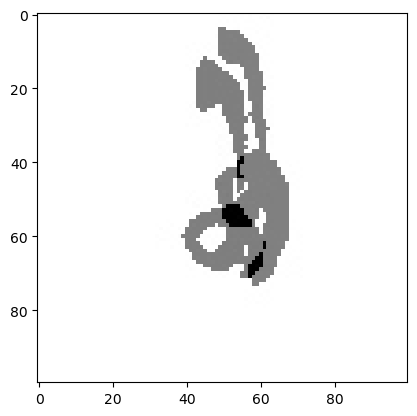

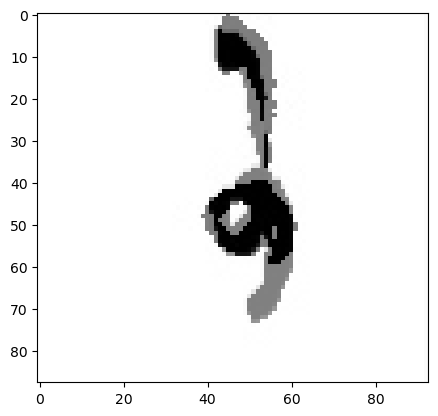

Image Similarity: 85.3035%


In [450]:
# Load images
imgTest = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + df.loc[df["char"] == "に"].iloc[10].image_file
)
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + df.loc[df["char"] == "に"].iloc[242].image_file
)

# Convert to grayscale.
imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
height, width = imgTest_grey.shape

# Configure ORB feature detector Algorithm with 1000 features.
orb_detector = cv2.ORB_create(1000)

# Extract key points and descriptors for both images
(kpsA, descsA) = orb_detector.detectAndCompute(imgTest, None)
(kpsB, descsB) = orb_detector.detectAndCompute(imgRef, None)

# Display keypoints for reference image in green color
imgKp_Ref = cv2.drawKeypoints(imgRef, kpsA, 0, (0, 222, 0), None)

# cv2_imshow(imgKp_Ref)
# plt.show()

# Match features between two images using Brute Force matcher with Hamming distance
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# match the features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)

# Match the two sets of descriptors.
matches = matcher.match(descsA, descsB, None)

# sort the matches by their distance (the smaller the distance,
# the "more similar" the features are)
matches = sorted(matches, key=lambda x: x.distance)
# keep only the top matches
keep = int(len(matches) * 0.5)
matches = matches[:keep]
# check to see if we should visualize the matched keypoints

matchedVis = cv2.drawMatches(imgTest, kpsA, imgRef, kpsB, matches, None)
# cv2_imshow(matchedVis)
# plt.show()

# allocate memory for the keypoints (x, y)-coordinates from the
# top matches -- we'll use these coordinates to compute our
# homography matrix
ptsA = np.zeros((len(matches), 2), dtype="float")
ptsB = np.zeros((len(matches), 2), dtype="float")
# loop over the top matches
for i, m in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt
# compute the homography matrix between the two sets of matched
# points
# (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
# use the homography matrix to align the images
H = np.float32(
    [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
)
(h, w) = imgRef.shape[:2]
aligned = cv2.warpAffine(imgTest, H, (w, h))

w_t = math.ceil(H[0, 2])
h_t = math.ceil(H[1, 2])

fig = plt.figure(frameon=False)
cv2_imshow(imgRef)
cv2_imshow(imgTest, alpha=0.5)
plt.show()

fig = plt.figure(frameon=False)
cv2_imshow(imgRef[h_t:, :w_t])
cv2_imshow(aligned[h_t:, :w_t], alpha=0.5)
plt.show()

# Compute SSIM between the two images
(score, diff) = structural_similarity(
    imgRef[h_t:, :w_t, 0], aligned[h_t:, :w_t, 0], full=True
)
print("Image Similarity: {:.4f}%".format(score * 100))